In [22]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

Radon measurements dataset:
 * $x_n \in \{0, 1\}$: measurement in house $n$ has been taken in the basement $0$ or on the ground floor $1$
 * $g_n \in \{0, 1, \dots, 84\}$: county that house $n$ is in
 * $y_n$: the log-radon contentration at house $n$


In [360]:
df = pl.read_csv("radon.csv")
df.select("floor", "county_code", "log_radon").head()

floor,county_code,log_radon
f64,i64,f64
1.0,0,0.832909
0.0,0,0.832909
0.0,0,1.098612
0.0,0,0.09531
0.0,1,1.163151


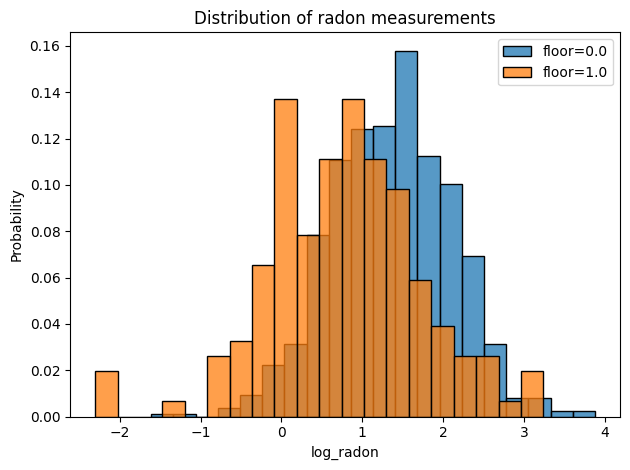

In [530]:
sns.histplot(data=df.filter(floor=0.0)["log_radon"], label="floor=0.0", stat = "probability", bins=20)
sns.histplot(data=df.filter(floor=1.0)["log_radon"], label="floor=1.0", stat = "probability", bins=20)
plt.xlabel("log_radon")
plt.legend()
plt.title("Distribution of radon measurements")
plt.tight_layout()

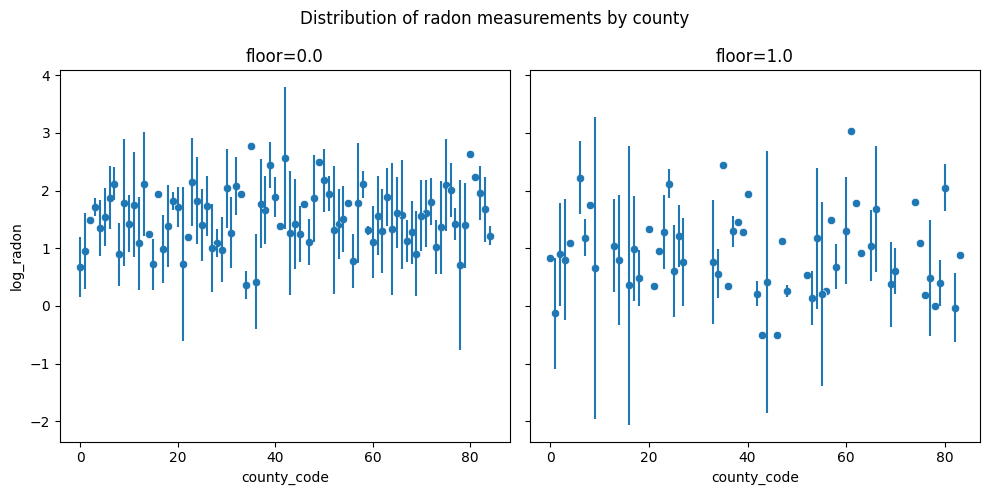

In [531]:
df_county1 = df.filter(floor=1.0).group_by("county_code").agg(pl.mean("log_radon"), pl.std("log_radon").alias("std_log_radon"))
df_county2 = df.filter(floor=0.0).group_by("county_code").agg(pl.mean("log_radon"), pl.std("log_radon").alias("std_log_radon"))

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.scatterplot(df_county1, x="county_code", y="log_radon", ax=axs.flat[1])
axs.flat[1].errorbar(df_county1["county_code"], df_county1["log_radon"], yerr=df_county1["std_log_radon"], linestyle="")
axs.flat[1].set_title("floor=1.0")
sns.scatterplot(df_county2, x="county_code", y="log_radon", ax=axs.flat[0])
axs.flat[0].errorbar(df_county2["county_code"], df_county2["log_radon"], yerr=df_county2["std_log_radon"], linestyle="")
axs.flat[0].set_title("floor=0.0")

fig.suptitle("Distribution of radon measurements by county")
fig.tight_layout()

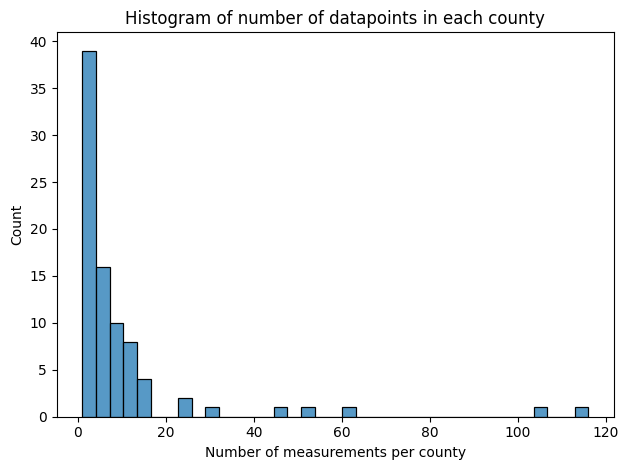

In [521]:
sns.histplot(data=df.group_by("county_code").agg(pl.len().alias("Number of measurements per county")), x="Number of measurements per county");
plt.title("Histogram of number of datapoints in each county")
plt.tight_layout();

We model the log-radon contentration by the following model
$$ p(y_n | x_n, g_n=j, \theta) = \mathcal{N}(y_n | \alpha_j + \beta_j x_n, \sigma_y^2) $$
with
$$ \alpha_j \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2), $$

$$ \beta_j \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) $$

and weak hyper-priors
$$ \mu_{\alpha, \beta} \sim \mathcal{N}(0, 1), \; \; \sigma_{\alpha, \beta, y} \sim \mathcal{C}_{+}(1) $$

The overall parameters of the model are:
$$ \theta = (\mu_{\alpha}, \mu_{\beta}, \sigma_{\alpha}, \sigma_{\beta}, \sigma_{y}, \alpha_{j=0}^{84}, \beta_{j=0}^{84}) $$

# Naive MCMC implementation

In [498]:
# Initialise the parameters by sampling the prior
params = np.zeros(5 + 85 + 85)
mu_a = 0
mu_b = 1
sigma_a = 2
sigma_b = 3
sigma_y = 4
params[0:2] = np.random.randn(2)
params[2:5] = np.abs(np.random.standard_cauchy(3))
params[5:90] = params[mu_a] + params[sigma_a] * np.random.randn(85)
params[90:175] = params[mu_b] + params[sigma_b] * np.random.randn(85)

In [499]:
d_norm = sp.stats.norm()
d_cauchy = sp.stats.halfcauchy()

df_data = df.select("floor", "county_code", "log_radon").sort("county_code")
data_floor = df_data["floor"].to_numpy()
data_county = df_data["county_code"].to_numpy()
data_radon = df_data["log_radon"].to_numpy()

def log_prob(params):
    p = 0
    # Priors
    p += np.sum(sp.stats.norm.logpdf(params[[mu_a, mu_b]]))
    p += np.sum(sp.stats.halfcauchy.logpdf(params[[sigma_a, sigma_b, sigma_y]]))
    if np.isneginf(p):
        return p
        
    p += np.sum(sp.stats.norm.logpdf(params[5:90], loc=params[mu_a], scale=params[sigma_a]))
    p += np.sum(sp.stats.norm.logpdf(params[90:175], loc=params[mu_b], scale=params[sigma_b]))

    # Main model
    p += np.sum(sp.stats.norm.logpdf(
        data_radon,
        loc=params[5 + data_county] + data_floor * params[90 + data_county],
        scale=params[sigma_y]
    )) 
    return p

In [500]:
step_sizes = np.concatenate([
    0.2 * np.ones(2),
    0.1 * np.ones(3),
    0.5 * np.ones(85),
    0.5 * np.ones(85)
])

In [501]:
N_accept = 0
N_tries = 0
res = []

In [513]:
# Random walk Metropolis Hastings
N_steps = 10000

current_log_prob = log_prob(params)
for i in range(N_steps):
    for j in range(len(params)):
        c = np.random.randint(175)
        new_params = params.copy()
        new_params[c] += step_sizes[c] * np.random.randn()
        new_log_prob = log_prob(new_params)
    
        N_tries += 1
        if not np.isneginf(new_log_prob) and np.exp(new_log_prob - current_log_prob) > np.random.rand():
            # Accept
            N_accept += 1
            params = new_params
            current_log_prob = new_log_prob
        else:
            pass

    res.append(params)

print(f"Acceptance ratio: {N_accept / N_tries}")

Acceptance ratio: 0.44514857142857145


<Axes: >

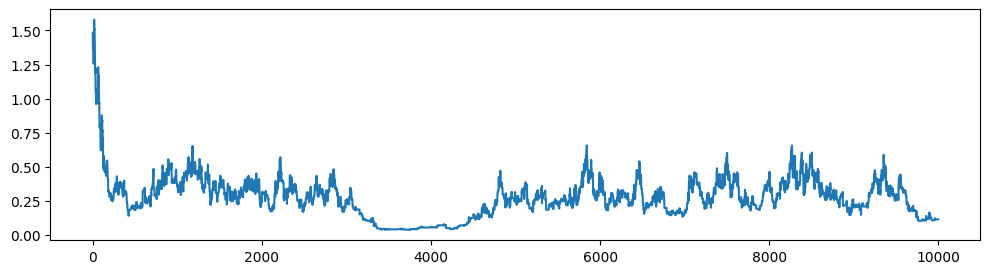

In [514]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.lineplot([x[3] for x in res], ax=ax)

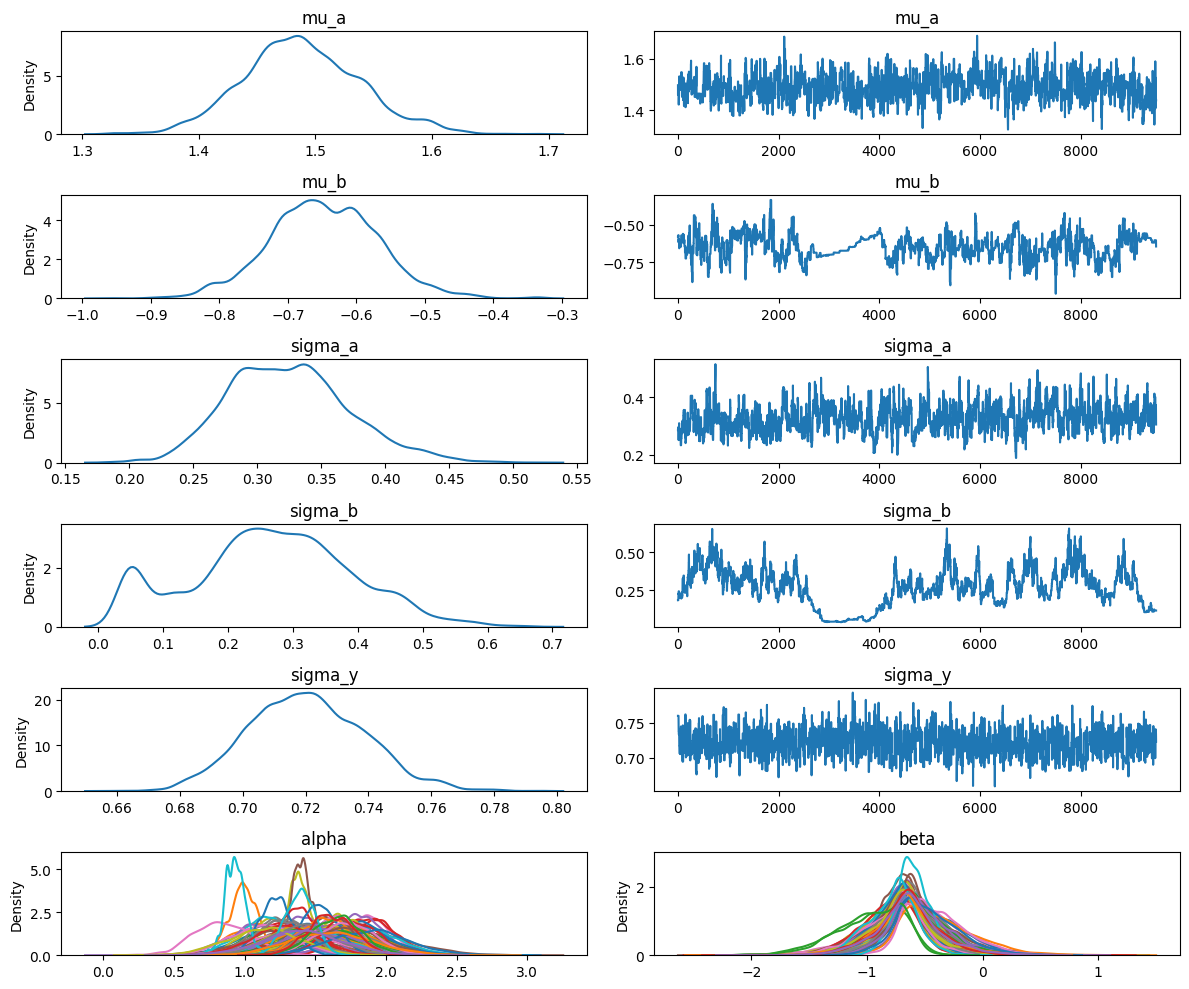

In [515]:
res_no_burnin = res[500:]

axs_title = ["mu_a", "mu_b", "sigma_a", "sigma_b", "sigma_y"]

fig, axs = plt.subplots(6, 2, figsize=(12,10))

for i in range(5):
    axs[i, 1].plot([x[i] for x in res_no_burnin])
    sns.kdeplot([x[i] for x in res_no_burnin], ax=axs[i, 0])
    axs[i, 0].set_title(axs_title[i])
    axs[i, 1].set_title(axs_title[i])

for i in range(85):
    sns.kdeplot([x[5+i] for x in res_no_burnin], ax=axs[5,0])
    axs[5,0].set_title("alpha")

for i in range(85):
    sns.kdeplot([x[90+i] for x in res_no_burnin], ax=axs[5,1])
    axs[5,1].set_title("beta")

fig.tight_layout()

# PyMC implementation

In [263]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [266]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=1)
    sigma_a = pm.HalfCauchy("sigma_alpha", beta=1)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=1)
    sigma_b = pm.HalfCauchy("sigma_beta", beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, shape=len(df_data.select("county_code").unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("beta", mu=mu_b, sigma=sigma_b, shape=len(df_data.select("county_code").unique()))

    # Model error
    eps = pm.HalfCauchy("eps", beta=1)

    # Expected value
    radon_est = a[data_county] + b[data_county] * data_floor

    # Data likelihood
    y_like = pm.Normal("y_like", mu=radon_est, sigma=eps, observed=data_radon)

In [340]:
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=5000)

Sampling 4 chains, 610 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:11

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.
There were 610 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


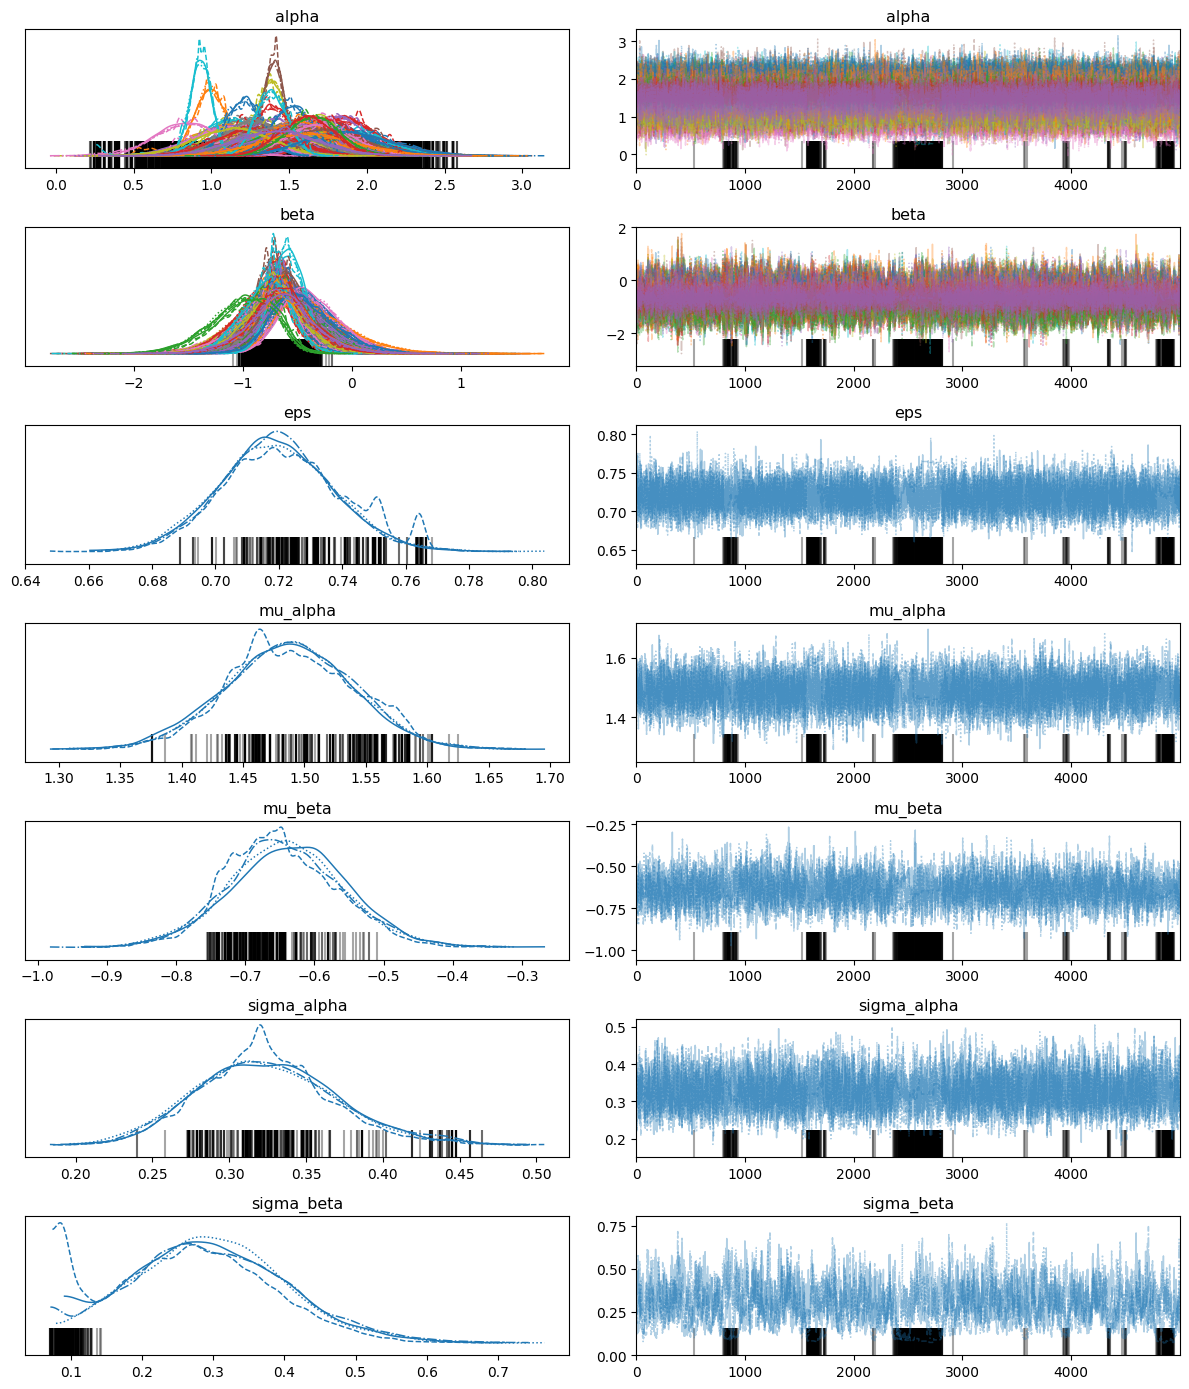

In [341]:
pm.plot_trace(hierarchical_trace);
plt.tight_layout()

# Funnel problem

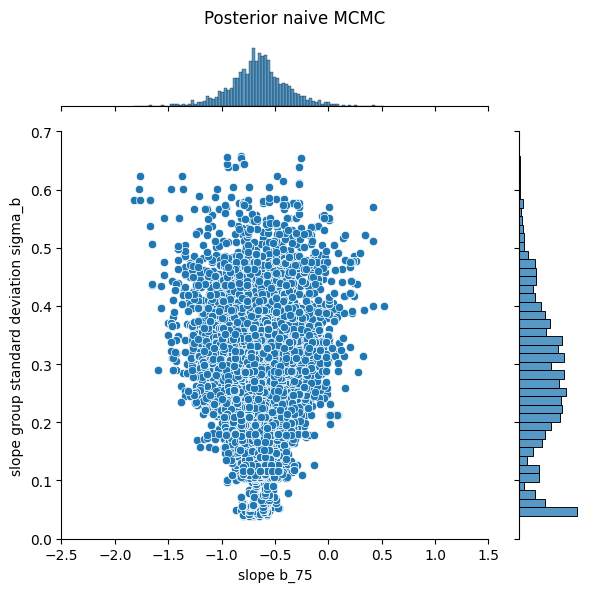

In [526]:
x = pd.Series([x[90+75] for x in res_no_burnin], name="slope b_75")
y = pd.Series([x[sigma_b] for x in res_no_burnin], name="slope group standard deviation sigma_b")

sns.jointplot(x=x, y=y, ylim=(0, 0.7), xlim=(-2.5, 1.5))
plt.suptitle("Posterior naive MCMC")
plt.tight_layout()

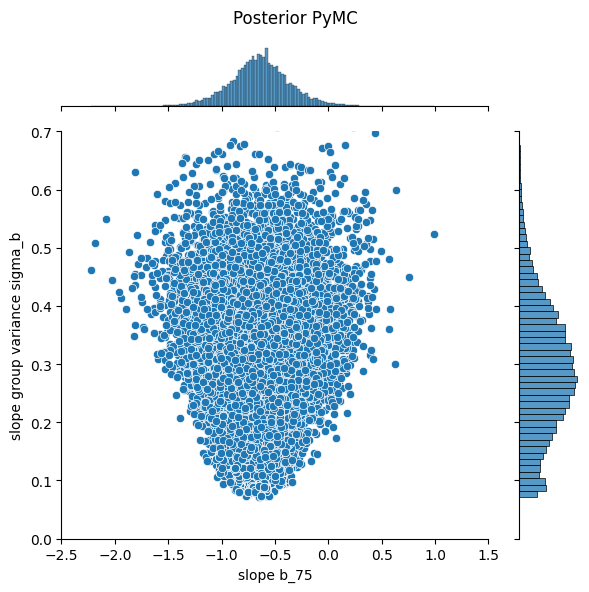

In [527]:
x = pd.Series(hierarchical_trace.posterior["beta"][:, :, 75].to_numpy().reshape(-1), name="slope b_75")
y = pd.Series(hierarchical_trace.posterior["sigma_beta"].to_numpy().reshape(-1), name="slope group variance sigma_b")

sns.jointplot(x=x, y=y, ylim=(0, 0.7), xlim=(-2.5, 1.5))
plt.suptitle("Posterior PyMC")
plt.tight_layout()

## Non-central model

In [355]:
n_counties = len(df_data.select("county_code").unique())
with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=1)
    sigma_a = pm.HalfCauchy("sigma_alpha", beta=1)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=1)
    sigma_b = pm.HalfCauchy("sigma_beta", beta=1)

    # Transformed:
    a_offset = pm.Normal("alpha_offset", mu=0, sigma=1, shape=n_counties)
    a = pm.Deterministic("alpha", mu_a + a_offset * sigma_a)

    # Now:
    b_offset = pm.Normal("beta_offset", mu=0, sigma=1, shape=n_counties)
    b = pm.Deterministic("beta", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy("eps", 5)

    radon_est = a[data_county] + b[data_county] * data_floor

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data_radon)

In [356]:
with hierarchical_model_non_centered:
    hierarchical_non_central_trace = pm.sample(draws=5000)

Sampling 4 chains, 40 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:11

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


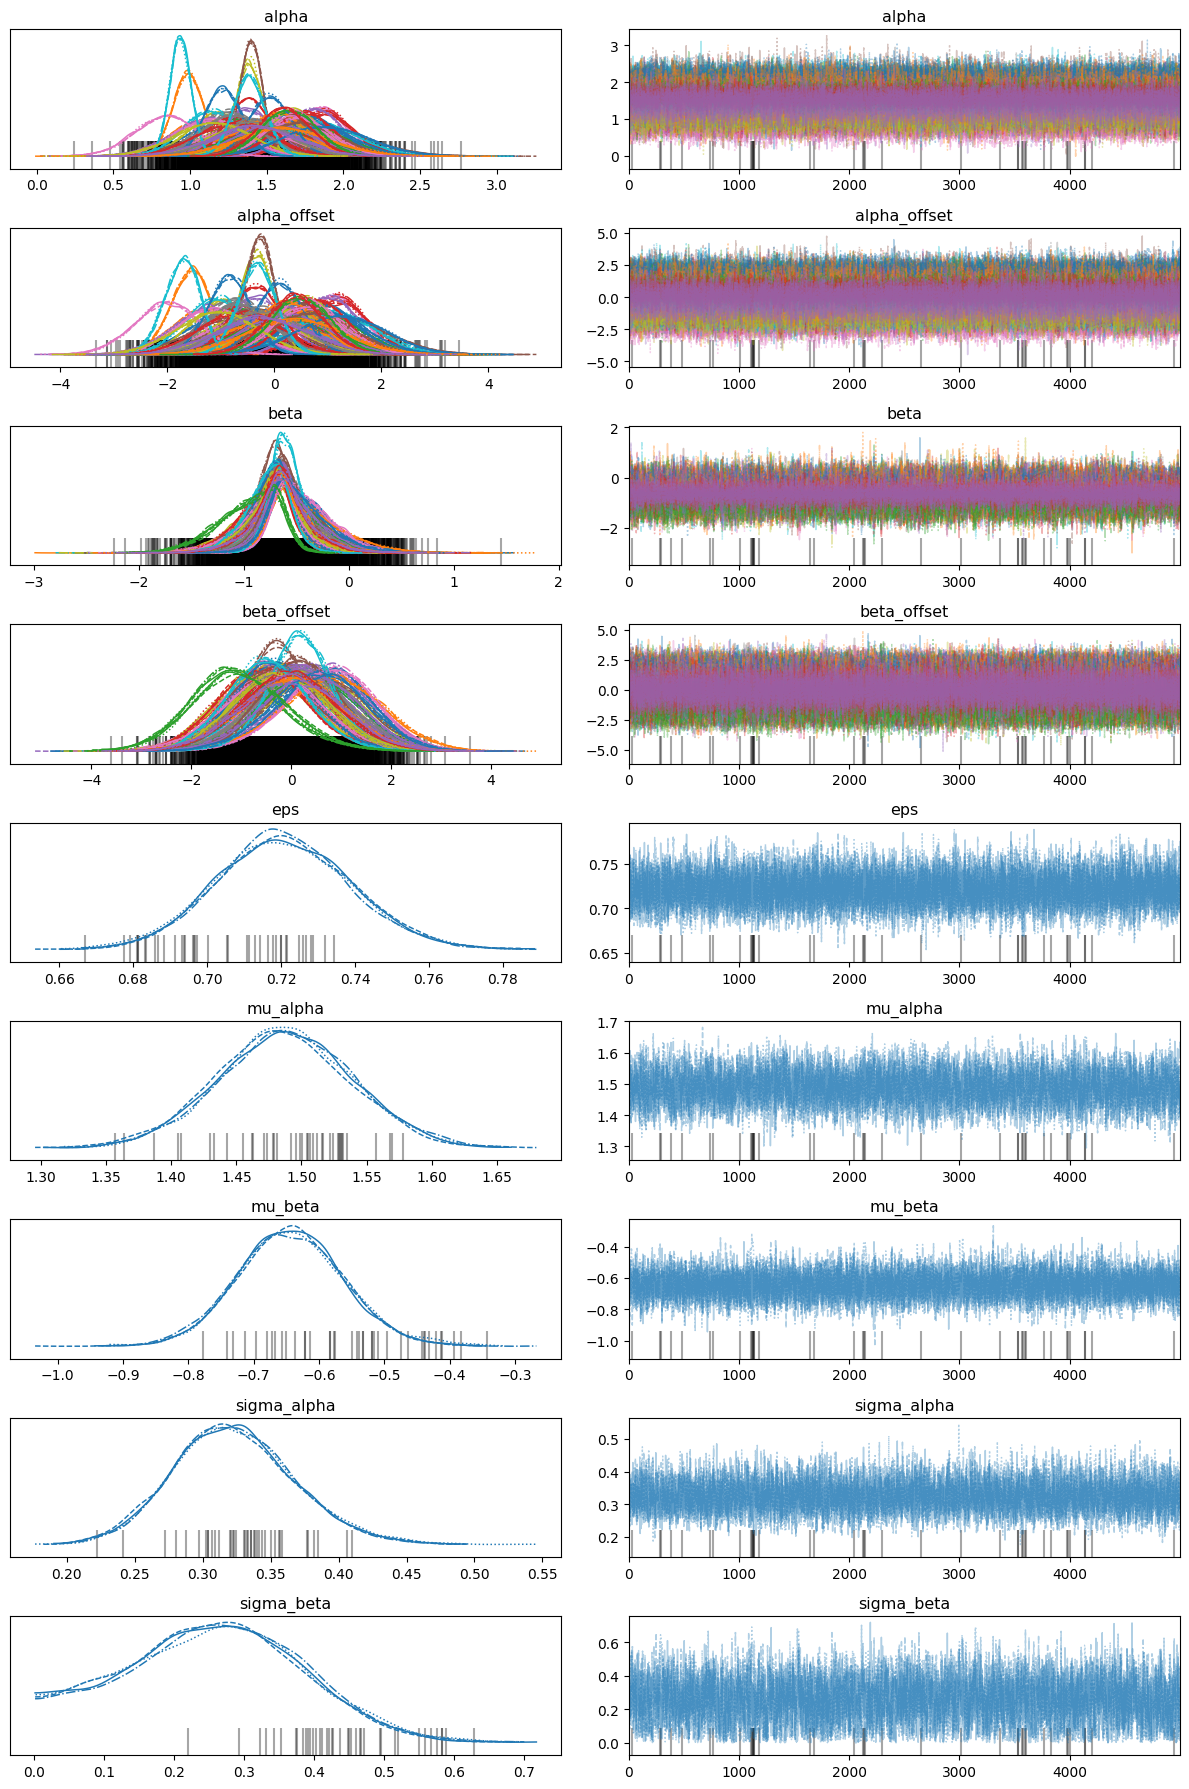

In [516]:
pm.plot_trace(hierarchical_non_central_trace);
plt.tight_layout()

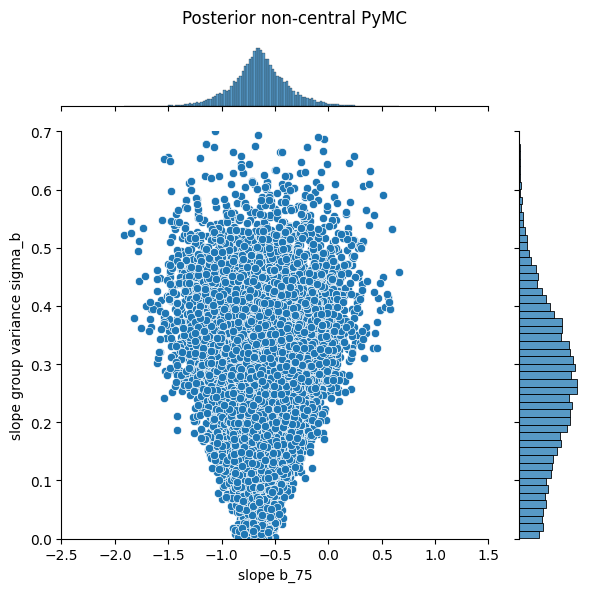

In [529]:
x = pd.Series(hierarchical_non_central_trace.posterior["beta"][:, :, 75].to_numpy().reshape(-1), name="slope b_75")
y = pd.Series(hierarchical_non_central_trace.posterior["sigma_beta"].to_numpy().reshape(-1), name="slope group standard deviation sigma_b")

sns.jointplot(x=x, y=y, ylim=(0, 0.7), xlim=(-2.5, 1.5))
plt.suptitle("Posterior non-central PyMC")
plt.tight_layout()